# **Лабораторна робота №1**
### з дисципліни **"Інтелектуальні системи підтримки прийняття рішень"**

##### **За темою:** "Дослiдження збіжності градієнтних алгоритмів навчання"

##### **Варіант:** 17

##### **Виконав:** Гавлицький Іван, КА-12

##### **Перевірила:** Недашкiвська Н.I.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### **Хід виконання роботи:**
Написати програму, яка реалiзує алгоритм градiєнтного спуску:
1. Розглянути функцiю вартостi
    $$E(w) = \frac{1}{2} σ^2-r^T_{xd} w+\frac{1}{2} w^T R_x w$$

    де $σ^2$ - константа,\
    $r_{xd} = (a, b)^T$,
    $$
    R_x = \begin{pmatrix} 
    1 & c\\ 
    c & 1
    \end{pmatrix},
    $$

    $a, b, c$ задані за варіантом.

2. Використовуючи метод градiєнтного спуску, обчислити значення $w^{(t)}, t = 1, 2, ..., T$ при заданому значеннi параметра швидкостi навчання $η$.
3. Побудувати траєкторiю вектору ваг $w^{(t)}$ у тривимiрному просторi i в площинi $W$.

4. Пiдiбрати швидкiсть навчання $η_1$, при якiй алгоритм градiєнтного спуску збiгається. Обрати $η_2$, за якої алгоритм розходиться. Для обох цих випадкiв побудувати траекторiї ваг.

In [2]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.offline import plot

### **Варіант завдання:**

In [3]:
a, b, c = 0.1, 0.3, 0.8
sigma_squared = 1

R_x = np.array([[1, c], [c, 1]])
r_xd = np.array([[a], [b]])

In [4]:
#cost function
def cost_value_func(sigma_squared, R_x, r_xd, w, grid_shape):
    cost_values = []

    for i in range(w.shape[1]):        
        cost_values.append(0.5 * sigma_squared - r_xd.T@w[:, i] + 0.5*w[:, i].T@R_x@w[:, i])

    return np.array(cost_values).reshape(grid_shape)

### **Візуалізація функції варитості**

Задамо простір $W$ для подальших графіків

In [5]:
w1_values = np.linspace(-10, 10, 100)
w2_values = np.linspace(-10, 10, 100)

w1, w2 = np.meshgrid(w1_values, w2_values)

W = np.array([np.ravel(w1), np.ravel(w2)])

Обчислення значень функції вартості

In [6]:
E = []

for i in range(W.shape[1]):
    w = W[:, i]
    E.append(1/2*sigma_squared - r_xd.T@w + 1/2*w.T@R_x@w)
    
E = np.array(E).reshape(w1.shape)

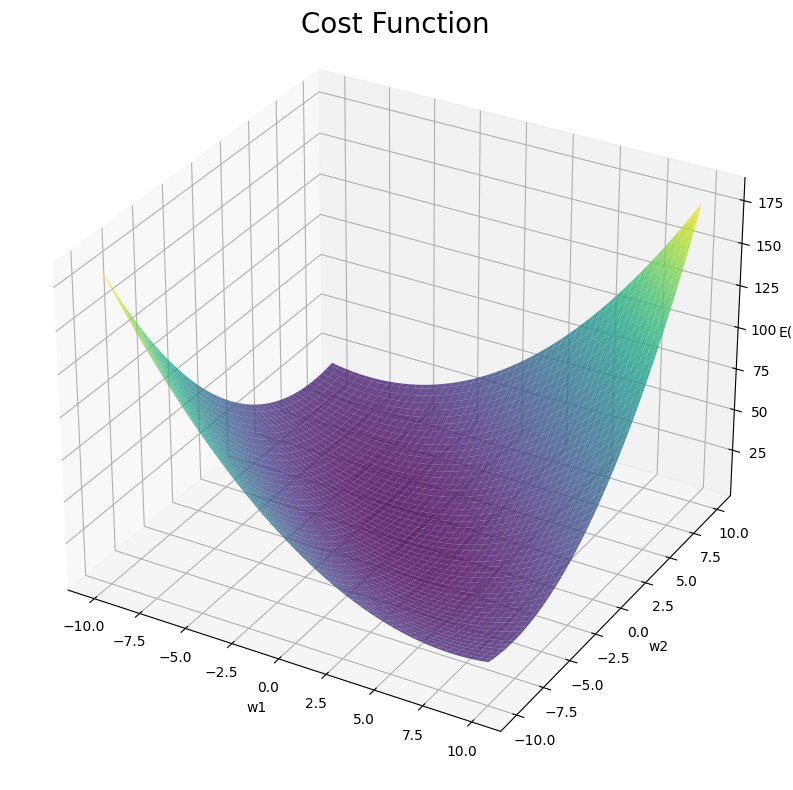

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(w1, w2, E, cmap='viridis', alpha=0.8)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('E(w)')

fig.tight_layout(rect=[0, 0, 1, 1])
fig.suptitle("Cost Function", fontsize=20)

plt.show()

### **Аналітичний підрахунок:**

##### **Оптимальний вектор ваг:**
$$w^* = R^{-1}_x r_{xd}$$

In [8]:
w_optim = np.linalg.inv(R_x) @ r_xd
w_optim

array([[-0.38888889],
       [ 0.61111111]])

##### **Критерій вибору швидкості навчання:**
$$0 < \eta < \frac{2}{\lambda_{max}}$$ <br>

In [9]:
lambda_max = 2/np.linalg.eigvals(R_x).max()
lambda_max

1.1111111111111112

$$0 < \eta < \frac{10}{9}$$

Також зазначимо, що $\frac{\lambda_{min}}{\lambda_{max}} = \frac{1}{9} \cong 0 \Rightarrow$ алгоритм збігається повільно.

In [10]:
np.linalg.eigvals(R_x).min() / np.linalg.eigvals(R_x).max()

0.11111111111111098

### **Реалізація основних функцій**

In [11]:
np.random.rand(2, 1)*10

array([[9.2038663 ],
       [1.52163747]])

In [12]:
class GradientDescending(object):
    
    def __init__(self, R, r, learning_rate, optimizer, learning_rate_type='const', n_iterations=100, betta_1=0.9, betta_2=0.999, epsilon=1e-8, k=10):
        self.R = R
        self.r = r
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.learning_rate_type = learning_rate_type
        self.n_iterations = n_iterations
        self.betta_1 = betta_1
        self.betta_2 = betta_2
        self.epsilon = epsilon
        self.k = k

        self.m_i = 0
        self.v_i = 0
        self.w_i = np.random.rand(2, 1)+10
        self.loss_history = np.zeros(n_iterations)
        self.w_history = np.zeros((2, n_iterations))
        self.grad_history = np.zeros((2, n_iterations))


    def calculate_energy_and_gradient(self):
        E_i = np.dot(self.w_i.T, np.dot(self.R, self.w_i)) / 2 - np.dot(self.r.T, self.w_i) + 1
        dw_i = np.dot(self.R, self.w_i) - self.r
        return E_i, dw_i
    

    def update_weights(self, dw_i): 
        if self.optimizer == 'GD':
            self.w_i -= self.learning_rate * dw_i
        elif self.optimizer == 'RMSprop':
            self.v_i = self.betta_2 * self.v_i + (1 - self.betta_2) * dw_i * dw_i
            self.w_i -= self.learning_rate * dw_i / np.sqrt(self.v_i + self.epsilon)
        elif self.optimizer == 'Adam':
            self.m_i = self.betta_1 * self.m_i + (1 - self.betta_1) * dw_i
            self.v_i = self.betta_2 * self.v_i + (1 - self.betta_2) * dw_i * dw_i
            self.w_i -= self.learning_rate * self.m_i / (np.sqrt(self.v_i) + self.epsilon)

    
    def adjust_learning_rate(self, i):
        if self.learning_rate_type == 'scheduled' and i % self.k == 0:
            self.learning_rate /= 2


    def gradient_descend(self):
    
        for i in range(self.n_iterations):
            E_i, dw_i = self.calculate_energy_and_gradient()
            
            self.loss_history[i] = E_i
            self.w_history[:, i] = self.w_i.reshape(2,)
            self.grad_history[:, i] = dw_i.reshape(2,)
            
            self.update_weights(dw_i)
                    
        return self.w_i, self.loss_history, self.w_history, self.grad_history
    

def plot_3d_surface(ax, w1, w2, cost_values):
    ax.plot_surface(w1, w2, cost_values, cmap='magma', lw=0.1, rstride=8, cstride=8, alpha=0.7)

def plot_2d_loss_curve(ax, iterations, losses):
    ax.plot(np.arange(iterations), losses)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')

def run_gradient_descent(optimizer, Rx, rxd, w0, learning_rate, iterations=100):

    print(f'{optimizer}:')
    print('____________________________________________________________________________________')

    gd = GradientDescending(R=Rx, r=rxd, learning_rate=learning_rate, optimizer=optimizer, n_iterations=iterations)
    w_best, losses, ws, grads = gd.gradient_descend()

    print("w:")
    print(w_best)

    print("etalon_w :")
    print(w0)
    
    print(f"Final loss value: {losses[-1]}")

    fig = plt.figure(figsize=(16, 8))
    
    ax1 = fig.add_subplot(121, projection='3d')
    plot_3d_surface(ax1, w1, w2, cost_values)
    ax1.plot(ws[0, :], ws[1, :], losses, zdir='z', label='GD', color='blue', marker='o')
    ax1.set(xlabel='w1', ylabel='w2', zlabel='E')
    ax1.set_title(f'3D Surface and Gradient Descent Path with {optimizer}')

    ax2 = fig.add_subplot(122)
    plot_2d_loss_curve(ax2, iterations, losses)
    ax2.set_title('2D Loss Curve')
    ax2.set_position([0.55, 0.1, 0.35, 0.8])  

    plt.show()

    return w_best, losses[-1]

### **Порівняння методів градієнтних спусків**

#### $0 < \eta < \frac{2}{\lambda_{max}}$

In [13]:
w0 = np.array(w_optim)
best_loss = cost_value_func(sigma_squared, R_x, r_xd, w0, (1, 1))
print(f'Best Loss Value: {best_loss[0][0]}')

Best Loss Value: 0.42777777777777776


GD:
____________________________________________________________________________________
w:
[[-0.388875  ]
 [ 0.61109723]]
etalon_w :
[[-0.38888889]
 [ 0.61111111]]
Final loss value: 0.9277777778253811


/tmp/ipykernel_33/1337164673.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



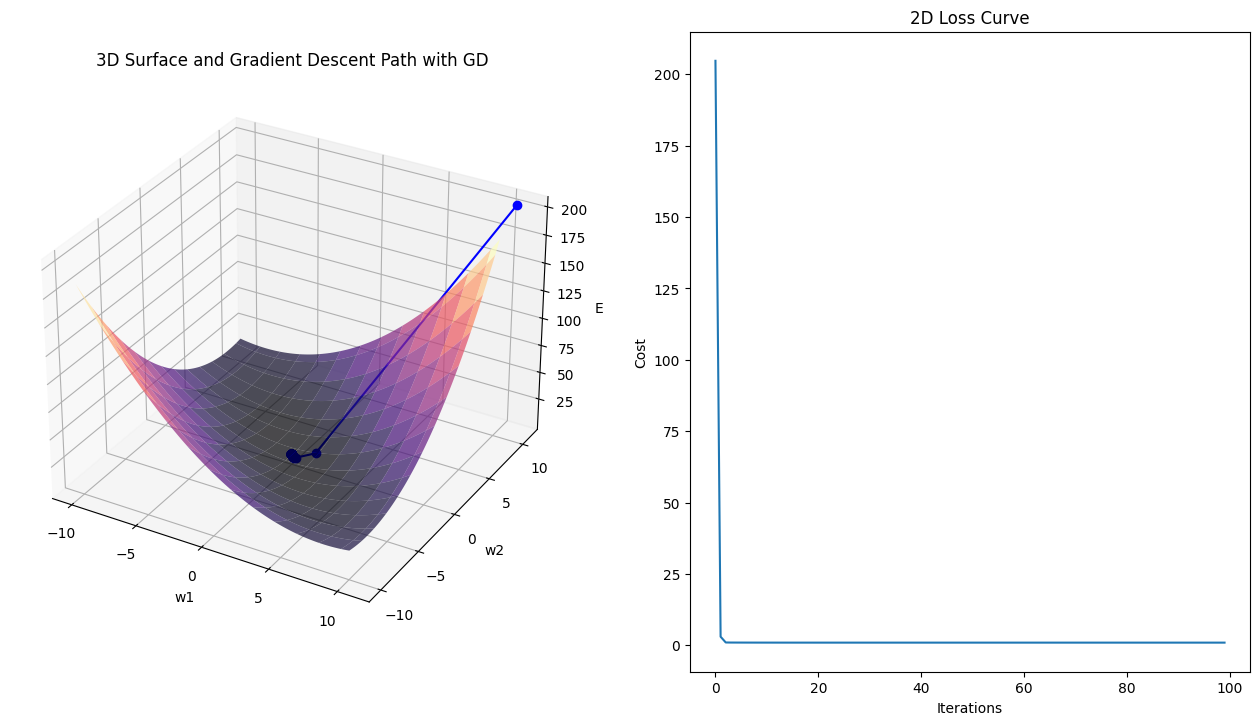

Adam:
____________________________________________________________________________________
w:
[[-0.42615411]
 [ 0.56698591]]
etalon_w :
[[-0.38888889]
 [ 0.61111111]]
Final loss value: 0.9298517709502053


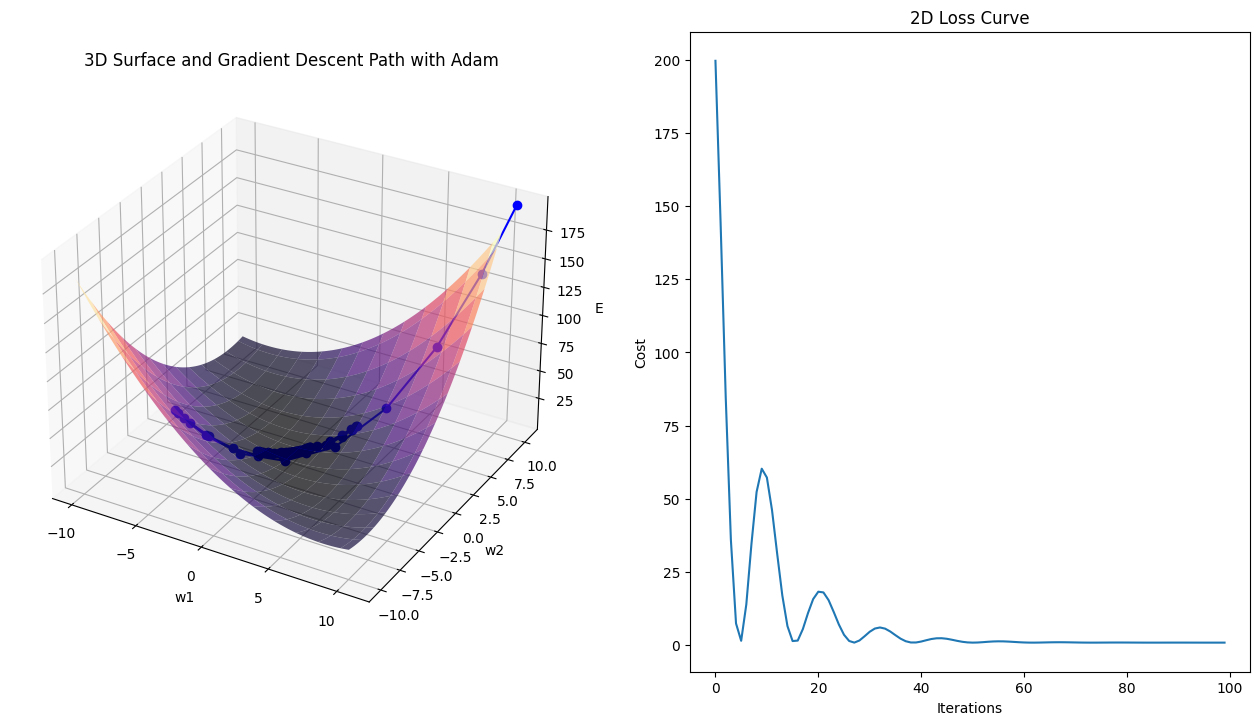

RMSprop:
____________________________________________________________________________________
w:
[[-0.38888885]
 [ 0.61111108]]
etalon_w :
[[-0.38888889]
 [ 0.61111111]]
Final loss value: 0.9277777777777781


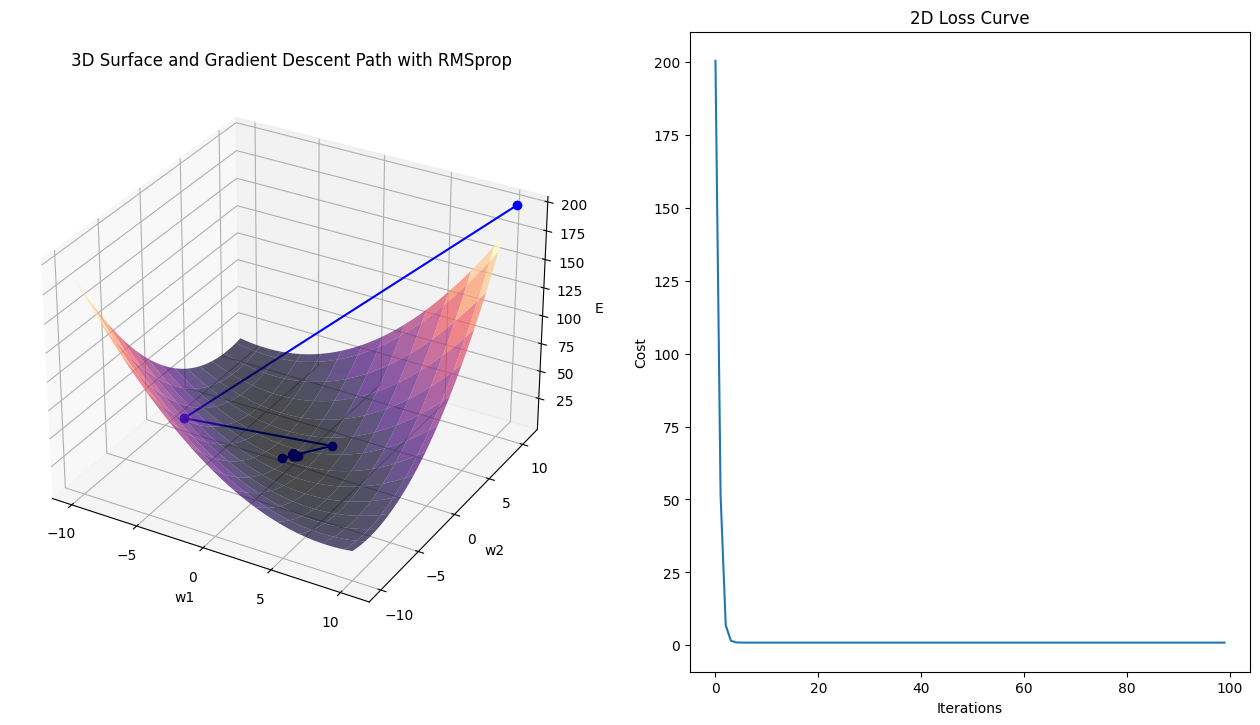

In [14]:
cost_values = cost_value_func(sigma_squared, R_x, r_xd, W, w1.shape)

results = [
    {'optimizer': 'sys', 'w1': 0.1, 'w2': 0.1, 'final_loss': best_loss[0][0]}
]

optimizers = ['GD', 'Adam', 'RMSprop']

for optimizer in optimizers:
    w_best, final_loss = run_gradient_descent(optimizer, R_x, r_xd, learning_rate=0.5, iterations=100, w0=w0)

    results.append({
        'optimizer': optimizer,
        'w1': w_best[0][0],
        'w2': w_best[1][0],
        'final_loss': final_loss,
        'learning_rate': 0.9
    })

#### $\eta > \frac{2}{\lambda_{max}}$ 

GD:
____________________________________________________________________________________
w:
[[-22.17744209]
 [-21.5940395 ]]
etalon_w :
[[-0.38888889]
 [ 0.61111111]]
Final loss value: 648.2010420490428


/tmp/ipykernel_33/1337164673.py:51: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



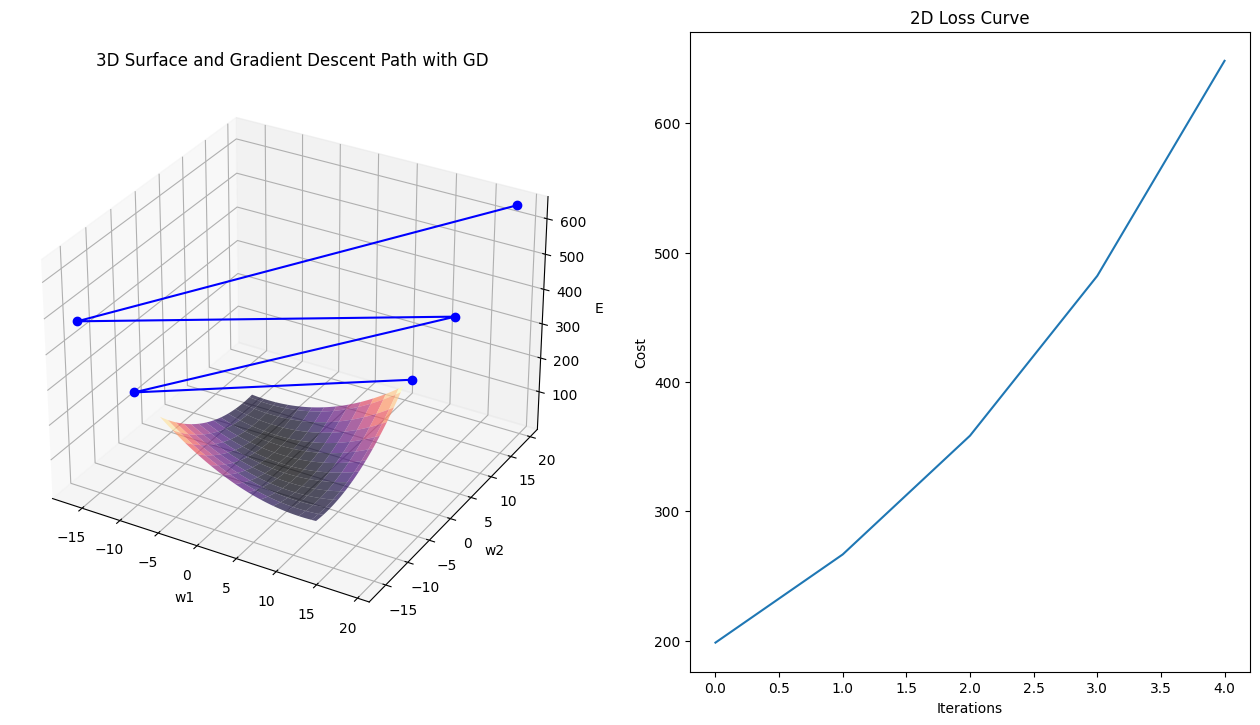

Adam:
____________________________________________________________________________________
w:
[[-0.34122908]
 [ 0.65413257]]
etalon_w :
[[-0.38888889]
 [ 0.61111111]]
Final loss value: 0.9298750778604506


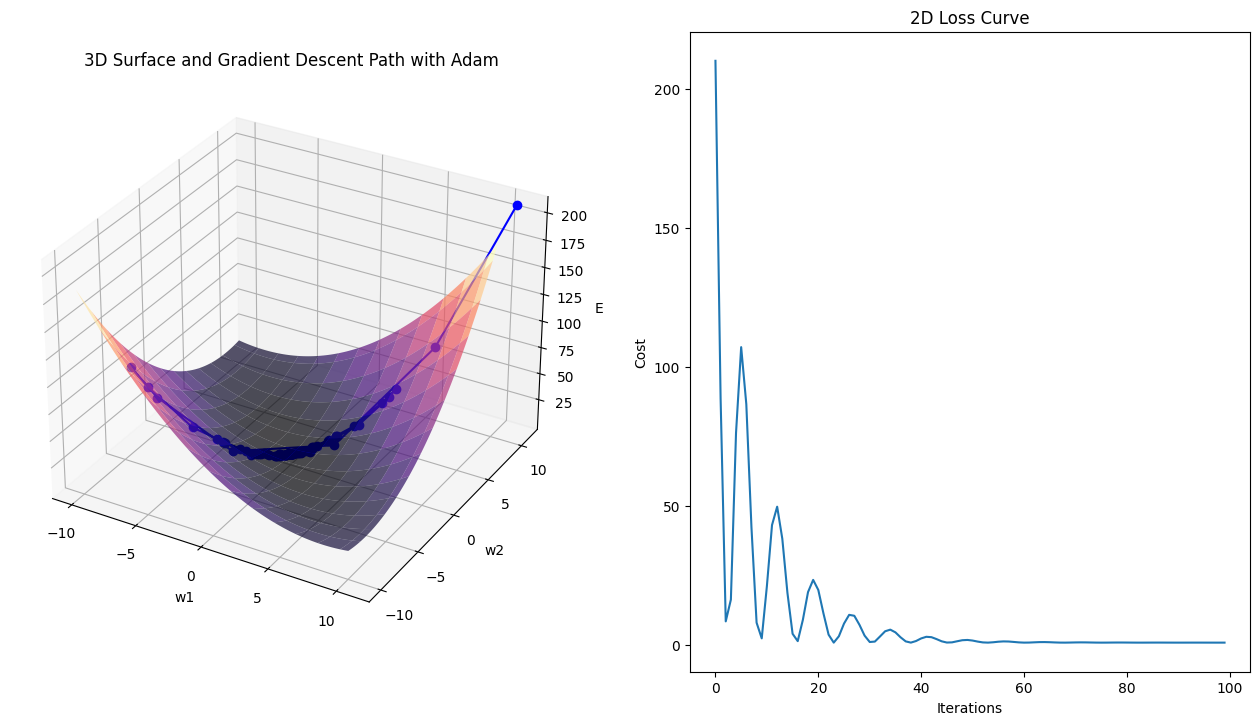

RMSprop:
____________________________________________________________________________________
w:
[[-0.38888864]
 [ 0.61111086]]
etalon_w :
[[-0.38888889]
 [ 0.61111111]]
Final loss value: 0.927777777777795


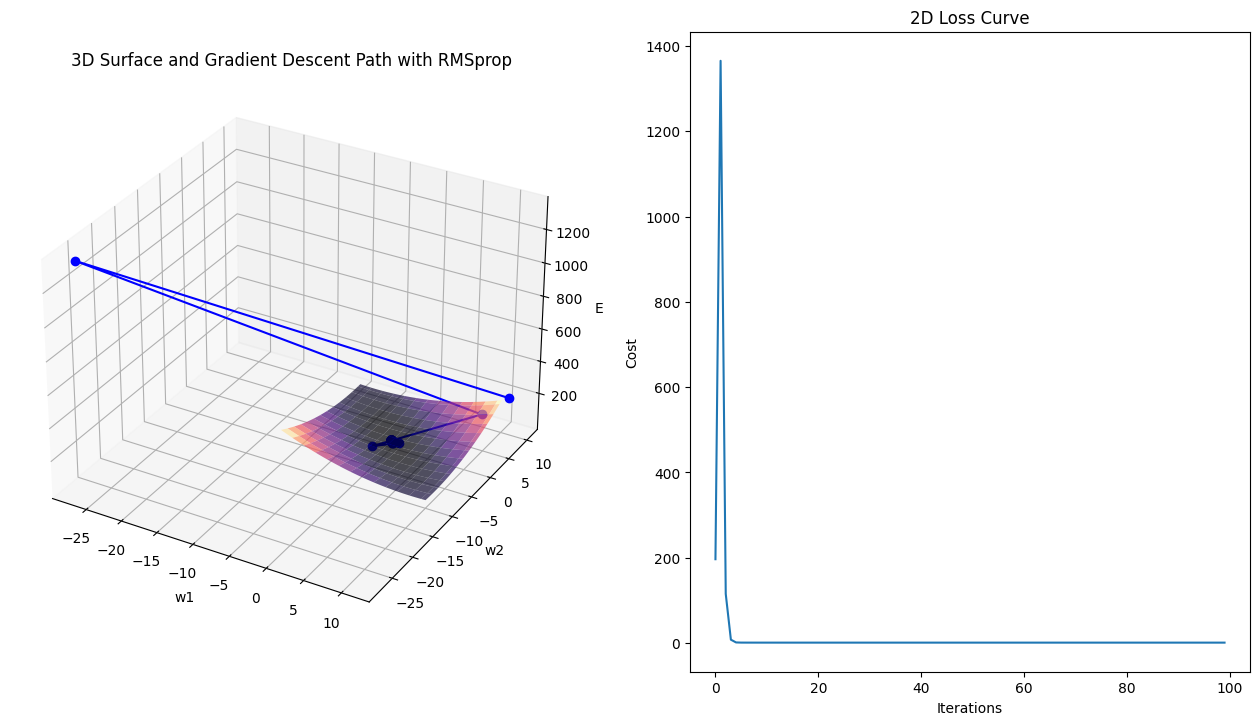

In [15]:
# iters = 5
results = [
    {'optimizer': 'sys', 'w1': 0.1, 'w2': 0.1, 'final_loss': best_loss[0][0]}
]

optimizers = ['GD', 'Adam', 'RMSprop']

for optimizer in optimizers:
    w_best, final_loss = run_gradient_descent(optimizer, R_x, r_xd, 
                                              learning_rate=1.2,
                                              iterations=5 if optimizer == 'GD' else 100,
                                              w0=w0)

    results.append({
        'optimizer': optimizer,
        'w1': w_best[0][0],
        'w2': w_best[1][0],
        'final_loss': final_loss
    })

Бачимо, що обидва адаптивних алгоритми збіглися навіть при $\eta > \frac{10}{9}$.